Введение

Цель работы - проанализировать данные сервиса аренды самокатов с целью увеличения количества пользователей с подпиской.

Данные содержат в себе информацию о пользователях (город, возраст, тип подписки), информацию о поездках (расстояние, длительность и дата совершения поездки), а также стоимость поездки для пользователей с подпиской и без.

План работы:

1. [Загрузка данных](#section1) 

2. [Предобработка данных (исследование пропусков, дублей, проверка типов данных)](#section2) 

3. [Исследовательский анализ: общая информация о пользователях и поездках (построение гистограмм, графиков, подсчет описательных статистик)](#section3) 

4. [Объединение данных](#section4) 

5. [ Подсчет выручки](#section5)

6. [Проверка гипотез о расстоянии, времени поездок и выручке от пользователей с подпиской по сравнению с пользователями без подписки](#section6) 

7. [Исследование эффективности промо-акций с раздачей промокодов и рассылкой push-уведомлений](#section7)

8. [Заключение](#section8)

<a id='section1'></a> 
####  1. Загрузка данных

Импорт библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats as st
from math import sqrt
from scipy.stats import binom, norm,  poisson

1.1 Загружаем информацию о пользователях.

In [2]:
pth1 = '/datasets/users_go.csv'
pth2 = 'https://code.s3.yandex.net/datasets/users_go.csv'

In [3]:
try:
     data_users = pd.read_csv(pth1)
except:
     data_users = pd.read_csv(pth2)    

Загружаем информацию о поездках.

In [4]:
pth1 = '/datasets/rides_go.csv'
pth2 = 'https://code.s3.yandex.net/datasets/rides_go.csv'

In [5]:
try:
     data_rides = pd.read_csv(pth1)
except:
     data_rides = pd.read_csv(pth2)   

Загружаем информацию о подписках.

In [6]:
pth1 = '/datasets/subscriptions_go.csv'
pth2 = 'https://code.s3.yandex.net/datasets/subscriptions_go.csv'

In [7]:
try:
     data_subscriptions = pd.read_csv(pth1)
except:
     data_subscriptions = pd.read_csv(pth2) 

1.2 Выводим первые строки набора данных о пользователях.

In [8]:
display(data_users.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Выведем общую информацию о датафрейме с пользователями.

In [9]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 42.9+ KB


В таблице 1565 строк, пропусков в данных нет.

Выводим первые строки набора данных о поездках.

In [10]:
display(data_rides.head(10))

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Выведем общую информацию о датафрейме с поездками.

In [11]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 494.1+ KB


В этой таблице гораздо больше данных: 18068 строк, пропусков нет.

Выводим первые строки набора данных о подписках.

In [12]:
display(data_subscriptions.head(10))

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В этой таблице всего 2 строки: информация о тарифах по подписке и без.

<a id='section2'></a> 
####  2. Предобработка данных

2.1 Приведем столбец date в таблице с поездками к формату даты и времени.

In [13]:
data_rides['date']=pd.to_datetime(data_rides['date'],format='%Y-%m-%d')

2.2 Создадим новый столбец с номером месяца.

In [14]:
data_rides['month']=data_rides['date'].dt.month

Проверим правильность нашего нового столбца: выведем первые 10 строк таблицы.

In [15]:
display(data_rides.head(10))

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Столбец добавлен корректно.

2.3 Выведем количество пропусков в каждом столбце в первой таблице.

In [16]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Аналогично во второй таблице.

In [17]:
data_rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропусков данных нет ни в таблице с пользователями, ни в таблице с поездками.

Проверим данные на наличие явных дубликатов.

In [18]:
data_users.duplicated().sum()

31

In [19]:
data_rides.duplicated().sum()

0

В таблице с пользователями обнаружилось 31 явный дубликат. Удалим эти строки с обновлением индексации.

In [20]:
data_users = data_users.drop_duplicates().reset_index(drop=True)

Проверим теперь число дубликатов.

In [21]:
data_users.duplicated().sum()

0

Все пропуски в таблице с пользователями удалены.

Выведем еще раз общую информацию об этом датафрейме.

In [22]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 42.0+ KB


На всякий случай проверим, нет ли одинаковых значений в столбце user_id.

In [23]:
data_users['user_id'].nunique()

1534

1534 уникальных зачения - ровно столько, сколько строк в таблице. Значит, дубликатов в этом столбце нет.

Данные готовы к обработке.

<a id='section3'></a> 
####  3. Исследовательский анализ данных

3.1 Проанализируем частоту встречаемости городов.

Посмотрим сначала, какие в принципе значения встречаются в столбце с названием города.

In [24]:
data_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Как видим, всего 8 городов. Посчитаем число пользователей в этих городах.

In [25]:
#Строим сводную таблицу по названию города, выводим число значений user_id в каждом городе
data_users.pivot_table(index='city', values='user_id',aggfunc='count').sort_values(by='user_id',ascending=False)

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


Построим круговую диаграмму, на которой отобразим частоту встречаемости городов.

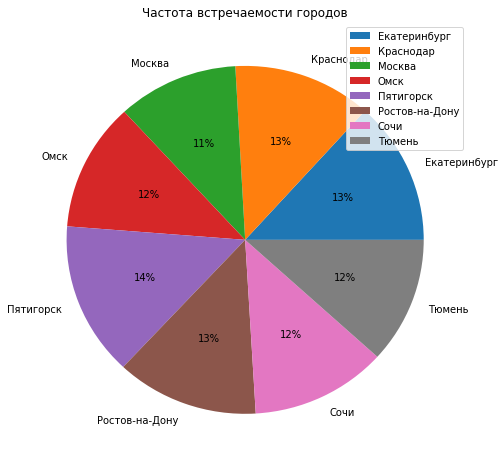

In [26]:
data_users.pivot_table(index='city', values='user_id',aggfunc='count').plot(kind='pie',y='user_id',figsize=(8,8),label='',autopct='%1.0f%%')
plt.title('Частота встречаемости городов') 

plt.show() 

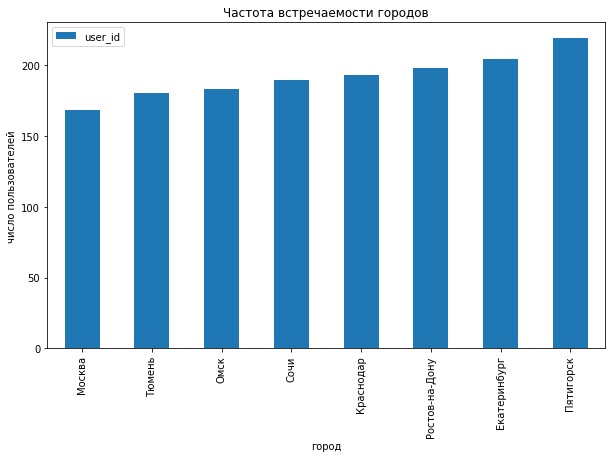

In [27]:
data_users.pivot_table(index='city', values='user_id',aggfunc='count').sort_values(by='user_id').plot(kind='bar',figsize=(10,6))
plt.title('Частота встречаемости городов') 
plt.xlabel('город') 
plt.ylabel('число пользователей') 
plt.show() 

Как видно, больше всего пользователей в Пятигорске,  меньше всего в Москве.

3.2 Соотношение пользователей с подпиской и без.

Посмотрим, сколько пользователей имеют подписку, сколько нет.

In [28]:
#Строим сводную таблицу по типу подписки, выводим число значений user_id для каждого типа
data_users.pivot_table(index='subscription_type', values='user_id',aggfunc='count')

,user_id
subscription_type,
free,835
ultra,699


Построим круговую диаграмму для типа подписки.

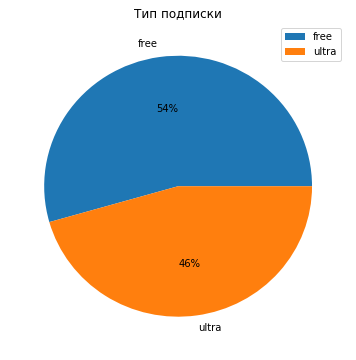

In [29]:
data_users.pivot_table(index='subscription_type', values='user_id',aggfunc='count').plot(kind='pie',y='user_id',figsize=(6,6),label='',autopct='%1.0f%%')
plt.title('Тип подписки') 

plt.show() 

Итак, 46% имеют подписку, 54% пользователей не имеют.

3.3 Возраст пользователей

Посмотрим на распределение пользователей по возрастам.

Построим столбчатую диаграмму для возраста пользователей.

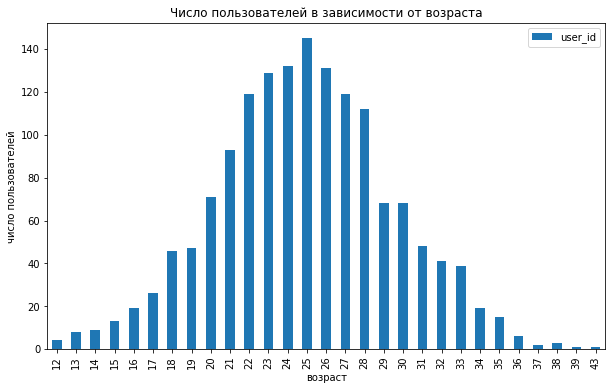

In [30]:
data_users.pivot_table(index='age', values='user_id',aggfunc='count').plot(kind='bar',figsize=(10,6))
plt.title('Число пользователей в зависимости от возраста') 
plt.xlabel('возраст') 
plt.ylabel('число пользователей') 
plt.show() 

Таким образом, наиболее активная категория пользователей - молодежь в возрасте около 25 лет. Самому молодому пользователю 12 лет, самому возрастному 43 года.

3.4 Расстояние, которое пользователь преодолел за одну поездку

Посмотрим, какие значения принимает переменная distance  в таблице с поездками.

In [31]:
display(data_rides['distance'].describe()) 

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднее расстояние, преодолеваемое пользователями, около 3 км, максимальное 7,2 км, минимальное 1 м. Медиана 3,1 км, что не сильно отличается от среднего, поэтому больших выбросов в данных нет. Стандартное отклонение 1,1 км, примерно треть от среднего,  разброс данных большой. 

Для визуализации можно посторить диаграмму размаха для переменной distance. 

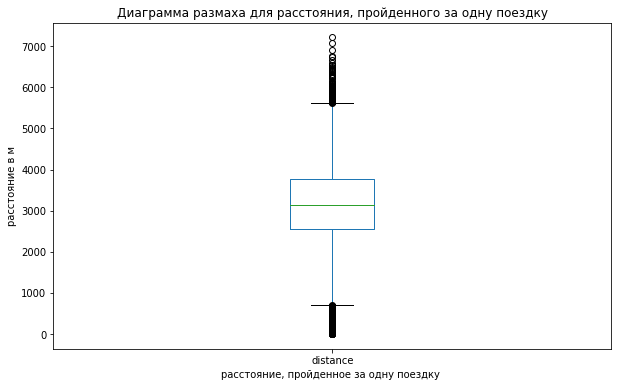

In [32]:
ax = data_rides['distance'].plot.box(figsize=(10,6))
plt.title('Диаграмма размаха для расстояния, пройденного за одну поездку') 
plt.xlabel('расстояние, пройденное за одну поездку ') 
plt.ylabel('расстояние в м') 
plt.show()

Как видно из диаграммы, очень много коротких поездок (до 1 км), которые находятся ниже первого квартиля, а также длинных поездок (больше 5,5 км), которые больше третьего квартиля. 

Построим гистограмму значений пройденных расстяний.

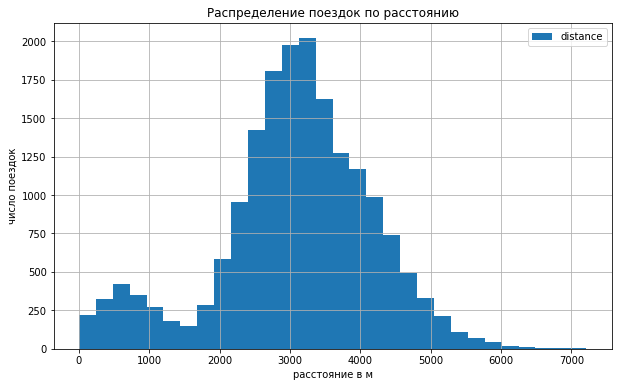

In [33]:
data_rides['distance'].hist(bins=30,figsize=(10,6),legend=True)
plt.title('Распределение поездок по расстоянию') 
plt.xlabel('расстояние в м') 
plt.ylabel('число поездок')  
plt.show() 

Из гистограммы видно, что чаще всего пройденное расстояние составило около 3 км. 
Есть небольшой пик в районе 0,5 км. По всей видимости, это новые пользователи, которые впервые захотели попробовать использовать самокат. 

3.5 Продолжительность поездок

Посмотрим, какие значения принимает переменная duration в таблице с поездками.

In [34]:
display(data_rides['duration'].describe()) 

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя длительность поездки составила 17,8 минут, медиана 17,7 минут, значит выбросов в данных нет. Максимальное время поездки составило 41 минуту, минимальное 0,5 минуты. Стандартное отклонение 6 минут, примерно треть от среднего. 

Диаграмма размаха для переменной duration:

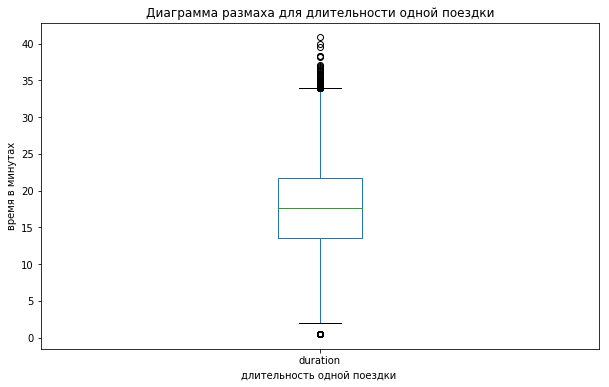

In [35]:
ax = data_rides['duration'].plot.box(figsize=(10,6))
plt.title('Диаграмма размаха для длительности одной поездки') 
plt.xlabel('длительность одной поездки ') 
plt.ylabel('время в минутах') 
plt.show()

Из диаграммы видно, что есть близкие к 0 значения, а также большие (больше 33 минут) значения.

Попробуем построить гистограмму для переменной duration.

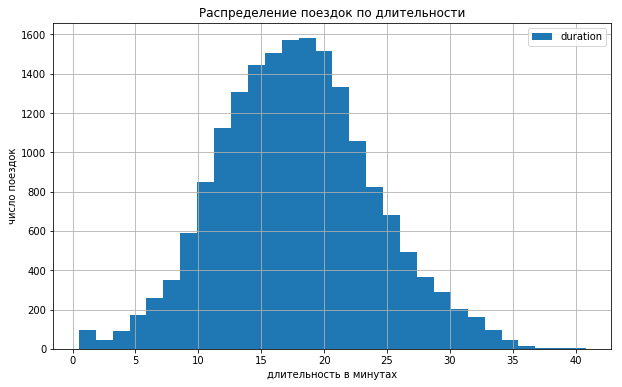

In [36]:
data_rides['duration'].hist(bins=30,figsize=(10,6),legend=True)
plt.title('Распределение поездок по длительности') 
plt.xlabel('длительность в минутах') 
plt.ylabel('число поездок')  
plt.show() 

Из гистограммы видно, что чаще всего поездки совершались за 18-19 минут. Вблизи 0 есть небольшой подъем, как и в случае с расстоянием, по всей видимости причины этих двух пиков одинаковые.

<a id='section4'></a> 
#### 4. Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [37]:
data_tmp=data_rides.merge(data_users)

Выведем первые 10 строк новой таблицы, чтобы проверить, что объединение прошло успешно.

In [38]:
display(data_tmp.head(10))

,user_id,distance,duration,date,month,name,age,city,subscription_type
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra


4.2 Создадим два датафрейма: о пользователях с подпиской и без.

In [39]:
#создаем датафрейм пользователей без подписки
data_free=data_tmp[data_tmp['subscription_type']=='free']

In [40]:
#создаем датафрейм пользователей с подпиской
data_ultra=data_tmp[data_tmp['subscription_type']=='ultra']

Выведем сначала общую информацию об этих датафреймах.

In [41]:
data_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 768.2+ KB


In [42]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 431.6+ KB


В таблице с подпиской 6500 записей, в таблице без подписки 11568, почти в два раза больше.

Теперь построим гистограммы для расстояния совершенных поездок для обоих датафреймов на одном графике.

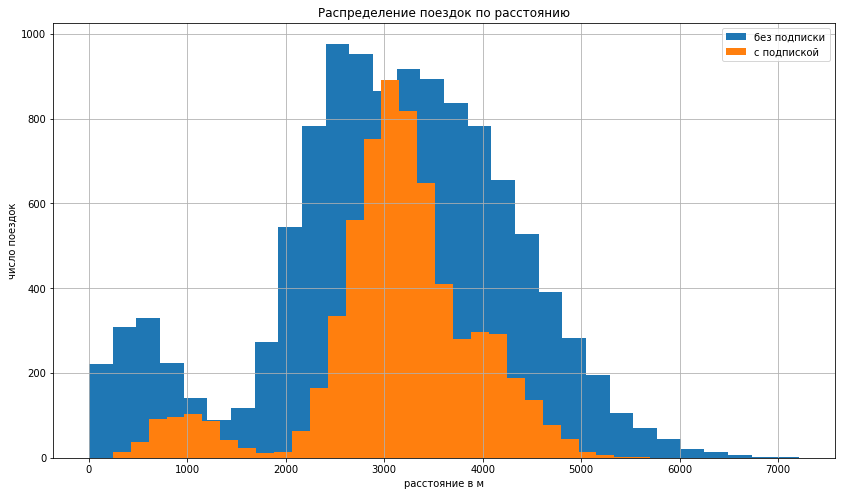

In [43]:
data_free['distance'].hist(bins=30,figsize=(14,8),label='без подписки')
plt.title('Распределение поездок по расстоянию') 
plt.xlabel('расстояние в м') 
plt.ylabel('число поездок')  
data_ultra['distance'].hist(bins=30,figsize=(14,8),label='с подпиской')
plt.legend()
  
plt.show() 

Из гистограммы видно, что у пользователей без подписки более широкий разброс значений расстояний вокруг среднего (тут необходимо еще учесть, что в таблице без подписки в два раза больше записей, чем в таблице с подпиской). Небольшой пик вблизи 0 у пользователей без подписки сдвинут левее, то есть самые короткие (по длине) поездки совершаются больше пользователями без подписки. 

Построим гистограмму для значений длительности одной поездки для пользователей с подпиской и без на одном графике.

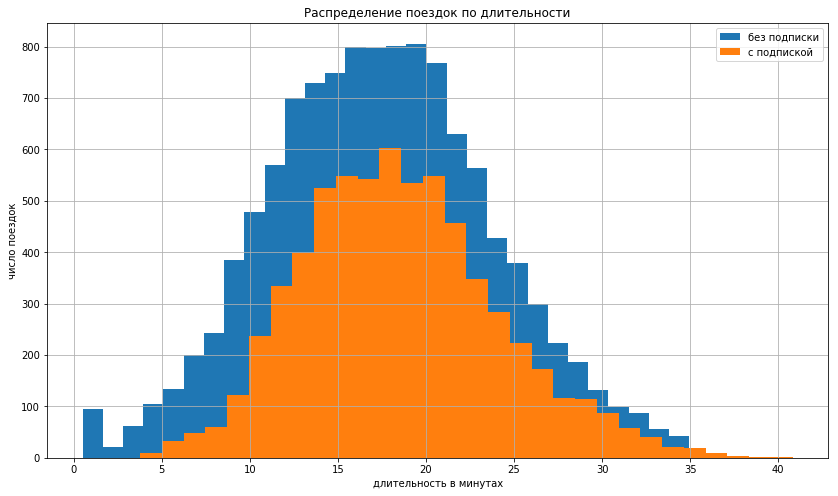

In [44]:
data_free['duration'].hist(bins=30,figsize=(14,8),label='без подписки')
plt.xlabel('длительность в минутах') 
plt.ylabel('число поездок')  
plt.title('Распределение поездок по длительности') 
data_ultra['duration'].hist(bins=30,figsize=(14,8),label='c подпиской')
 
plt.legend()
  
plt.show() 

Гистограммы в целом выглядят похоже (принимая во внимание, что в одном наборе данных почти в два раза больше). Но пик вблизи 0 приходится только на пользователей без подписки. 

<a id='section5'></a> 
####  5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках, включим в него суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц (данные приведены за один год).

Сначала добавим в объединенный датафрейм два столбца, которые нам будут необходимы для дальнейшей работы.

Поскольку для подсчета выручки нам понадобится округленная длительность поездки, то добавим в объединенный датафрейм столбец duration_round.

In [45]:
#округляем продолжительность каждой поездки
data_tmp['duration_round']=np.ceil(data_tmp['duration'])
display(data_tmp.head(10))

,user_id,distance,duration,date,month,name,age,city,subscription_type,duration_round
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,26.0
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,16.0
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,7.0
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,19.0
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,27.0
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,17.0
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,15.0
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,24.0
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,16.0
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,16.0


Добавим в таблицу еще столбец-индикатор подписки subscription: равен 0, если нет подписки, и 1, если есть. Он понадобится нам для построения сводной таблицы и подсчета выручки.

In [46]:
#функция, возвращающая 0 для строки 'free' и 1 в другом случае
def subscript (a):
    if a=='free':
        return 0
    else:
        return 1
#применяем эту функцию к столбцу subscription_type, получаем столбец subscription из 0 и 1
data_tmp['subscription']=data_tmp['subscription_type'].apply(subscript)
display(data_tmp.head(10))

,user_id,distance,duration,date,month,name,age,city,subscription_type,duration_round,subscription
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,26.0,1
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,16.0,1
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,7.0,1
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,19.0,1
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,27.0,1
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,17.0,1
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,15.0,1
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,24.0,1
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,16.0,1
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,16.0,1


Теперь создаем сводную таблицу, в которой:

distance_count	- количество поездок для каждого клиента за месяц,

distance_sum - суммарное расстояние, пройденной каждым клиентом за месяц,

duration_sum - суммарное время поездок для каждого клиента за месяц,

duration_round_sum - суммарное округленное время поездок для каждого клиента за месяц,

subscription_sum - индикатор наличия подписки (0 - нет подписки, другое число - есть подписка).

In [47]:
#Создаем сводную таблицу, группируем данные по user_id и month,к значениям distance, duration,duration_round,subscription применяем функции
#'count','sum' к первому и 'sum' к остальным
data_pivot = data_tmp.pivot_table(index=['user_id','month'],values=['distance','duration','duration_round','subscription'], 
                                  aggfunc={'distance':['count', 'sum'],'duration':['sum'],'duration_round':['sum'],'subscription':['sum']})
#объединяем мультииндекс в однострочный индекс
data_pivot.columns = list(map("_".join, data_pivot.columns))
display(data_pivot.head(10))

distance_count  distance_sum  duration_sum  duration_round_sum  \
user_id month                                                                   
1       1                   2   7027.511294     41.416640                42.0   
        4                   1    754.159807      6.232113                 7.0   
        8                   2   6723.470560     44.776802                46.0   
        10                  2   5809.911100     31.578017                32.0   
        11                  3   7003.499363     53.397424                56.0   
        12                  2   6751.629942     27.203912                28.0   
2       3                   3  10187.723006     60.959959                63.0   
        4                   2   6164.381824     39.048633                40.0   
        6                   1   3255.338202     13.851127                14.0   
        7                   2   6780.722964     46.170157                48.0   

               subscription_sum  
user_id month                    
1       1                     2  
        4                     1  
        8                     2  
        10                    2  
        11                    3  
        12                    2  
2       3                     3  
        4                     2  
        6                     1  
        7                     2

5.2 В этой сводной таблице создаем столбец с помесячной выручкой revenue.

Этот столбец создается из duration_round_sum и distance_count:

если есть подписка, то есть значение столбца subscription_sum больше 0, то доход равен 6* duration_round_sum + 199,

если нет подписки, то есть subscription_sum равно 0, то доход равен 50* distance_count+8* duration_round_sum.

In [48]:
data_pivot['revenue']=(data_pivot['subscription_sum']>0)*(6*data_pivot['duration_round_sum']+199)+(data_pivot['subscription_sum']==0)*(50*data_pivot['distance_count']+8*data_pivot['duration_round_sum'])
display(data_pivot)

distance_count  distance_sum  duration_sum  duration_round_sum  \
user_id month                                                                   
1       1                   2   7027.511294     41.416640                42.0   
        4                   1    754.159807      6.232113                 7.0   
        8                   2   6723.470560     44.776802                46.0   
        10                  2   5809.911100     31.578017                32.0   
        11                  3   7003.499363     53.397424                56.0   
...                       ...           ...           ...                 ...   
1534    6                   2   3409.468534     24.812678                26.0   
        8                   2   7622.453034     47.205960                48.0   
        9                   1   4928.173852     22.560373                23.0   
        11                  4  13350.015305     76.342174                78.0   
        12                  1   2371.711192     15.893917                16.0   

               subscription_sum  revenue  
user_id month                             
1       1                     2    451.0  
        4                     1    241.0  
        8                     2    475.0  
        10                    2    391.0  
        11                    3    535.0  
...                         ...      ...  
1534    6                     0    308.0  
        8                     0    484.0  
        9                     0    234.0  
        11                    0    824.0  
        12                    0    178.0  

[11331 rows x 6 columns]

Таким образом, реализован подсчет выручки для каждого пользователя за каждый месяц.

<a id='section6'></a> 
####  6. Проверка гипотез

6.1 Тратят ли пользователи с подпиской больше времени на поездки?

Здесь нужно проверить гипотезу о равенстве средних двух независимых выборок: длительности поездки для пользователей с подпиской и без. 

Альтернативная гипотеза: среднее первой генеральной совокупности меньше, чем второй. 

Обозначим средние значения для длительности поездки без подписки m_1, с подпиской  m_2.

Первая выборка data_free['duration'], вторая data_ultra['duration']. 

Тогда нулевая и альтернативная гипотеза имеют вид:

Н0: m_1 = m_2 

Н1: m_1 < m_2 

Применим t-тест для двух независимых выборок с аргументом alternative='less'.

In [49]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_free['duration'], data_ultra['duration'],alternative='less')

print('среднее длительности поездки без подписки:',data_free['duration'].mean())
print('среднее длительности поездки c подпиской:',data_ultra['duration'].mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

среднее длительности поездки без подписки: 17.39090929866398
среднее длительности поездки c подпиской: 18.541985162805805
p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Значит, пользователи с подпиской в целом тратят больше времени на поездки, чем пользователи без подписки.

6.2 Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м?

Здесь нужно проверить гипотезу о равентсве среднего генеральной совокупности расстояний, проезжаемых пользователями с подпиской, числу 3130, альтернативная гипотеза о том, что истинное среднее меньше 3130.

Обозначим среднее  расстояние, проезжаемое пользователями с подпиской, m .

Применим одновыборочный t-тест с аргументом alternative='less'.

Нулевая и альтернативная гипотеза имеют вид:

Н0: m = 3130

Н1: m >3130

In [50]:
prev_distance = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    data_ultra['distance'], 
    prev_distance,
    alternative='greater'
        )

print('среднее расстояние, проезжаемое пользователями с подпиской:',data_free['distance'].mean())
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

среднее расстояние, проезжаемое пользователями с подпиской: 3045.4952816718205
p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


p-значение получилось достаточно большое. Нет оснований отвергать нулевую гипотезу. Альтернативную гипотезу отвергаем, значит расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м

6.3 Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Здесь нужно проверить гипотезу о равенстве средних двух независимых выборок: выручки от пользователей с подпиской и без. 

Альтернативная гипотеза: среднее первой генеральной совокупности меньше, чем второй.

Обозначим средние значения для выручки от пользователей без подписки  m_1, с подпиской m_2.

Тогда нулевая и альтернативная гипотеза имеют вид:

Н0: m_1 = m_2 

Н1: m_1 < m_2 

Осталось только подготовить выборки.

Выделим из сводной таблицы data_pivot строки для пользователей без подписки.

In [51]:
data_1=data_pivot[data_pivot['subscription_sum']==0]

In [52]:
display(data_1.head(10))

distance_count  distance_sum  duration_sum  duration_round_sum  \
user_id month                                                                   
700     1                   1   2515.690719     14.944286                15.0   
        2                   5  13446.659764     85.829845                89.0   
        3                   1   3798.334905     18.243756                19.0   
        4                   1   2984.551206     15.424899                16.0   
        6                   2   5927.650988     28.077657                29.0   
        7                   2   4399.206279     20.595752                21.0   
        8                   1   4071.654669     16.370546                17.0   
        10                  2   6322.578618     42.621488                44.0   
        11                  3   8735.782625     31.116714                32.0   
701     1                   1   2676.472894     17.470598                18.0   

               subscription_sum  revenue  
user_id month                             
700     1                     0    170.0  
        2                     0    962.0  
        3                     0    202.0  
        4                     0    178.0  
        6                     0    332.0  
        7                     0    268.0  
        8                     0    186.0  
        10                    0    452.0  
        11                    0    406.0  
701     1                     0    194.0

Теперь выделим из сводной таблицы data_pivot строки для пользователей с подпиской.

In [53]:
data_2=data_pivot[data_pivot['subscription_sum']>0]

In [54]:
display(data_2.head(10))

distance_count  distance_sum  duration_sum  duration_round_sum  \
user_id month                                                                   
1       1                   2   7027.511294     41.416640                42.0   
        4                   1    754.159807      6.232113                 7.0   
        8                   2   6723.470560     44.776802                46.0   
        10                  2   5809.911100     31.578017                32.0   
        11                  3   7003.499363     53.397424                56.0   
        12                  2   6751.629942     27.203912                28.0   
2       3                   3  10187.723006     60.959959                63.0   
        4                   2   6164.381824     39.048633                40.0   
        6                   1   3255.338202     13.851127                14.0   
        7                   2   6780.722964     46.170157                48.0   

               subscription_sum  revenue  
user_id month                             
1       1                     2    451.0  
        4                     1    241.0  
        8                     2    475.0  
        10                    2    391.0  
        11                    3    535.0  
        12                    2    367.0  
2       3                     3    577.0  
        4                     2    439.0  
        6                     1    283.0  
        7                     2    487.0

 Выборки для выручки, которые мы будем сравнивать: data_1['revenue'] и data_2['revenue'].

Применим t-тест для двух независимых выборок с аргументом alternative='less'.

In [55]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_1['revenue'],data_2['revenue'],alternative='less')

print('средний доход от пользователей без подписки:',data_1['revenue'].mean())
print('среднее доход от пользователей с подпиской:',data_2['revenue'].mean())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

средний доход от пользователей без подписки: 328.6413651073845
среднее доход от пользователей с подпиской: 362.7921906022502
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Таким образом, отвергаем нулевую гипотезу в пользу альтернативной. Пользователи с подпиской в целом приносят больший доход, чем пользователи без подписки.

6.4 Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы? 

Для проверки гипотезы о равенстве среднего значения генеральной совокупности до и после изменения можно применить t-тест для двух  зависимых выборок с аргументом alternative='greater', то есть альтернативная гипотеза состоит в том, что истинное среднее генеральной совокупности после изменения стало меньше, чем было до изменения.

<a id='section7'></a> 
####  7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Продлевание подписки можно рассматривать как эксперимент Бернулли с вероятностью успеха p=0.1. Тогда сумма числа клиентов, продливших подписку, является случайной величиной, имеющей биномиальное распределение с параметрами  (N,p), где N - число всех клиентов, получивших промокоды.

При маленьком p и большом N биномиальное распределение может быть аппроксимировано распределением Пуассона с параметром p*N.

Возьмем для примера N=1000 и построим график распределения Пуассона с параметром p*N=100.

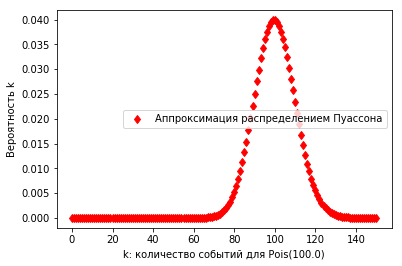

In [56]:
# задаем параметры биномиального распределения
n = 1000
p = 0.1
 
# считаем параметр распределения Пуассона для аппроксимации
lmbd = n * p
 
# задаем диапазон значений k для построения графика
max_value = 150
 
poisson_probs = []
for k in range(max_value + 1):
    # рассчитываем значения вероятности распределения Пуассона
    poisson_prob = poisson.pmf(k, lmbd)
    poisson_probs.append(poisson_prob)
 # рисуем графики
plt.plot(range(max_value + 1), poisson_probs, 'rd',
         label='Аппроксимация распределением Пуассона')
plt.xlabel(f'k: количество событий для Pois({lmbd})')
plt.ylabel('Вероятность k')
plt.legend()
plt.show()
 

Обозначим X случайную величину с распределением Пуассона с параметром lambda=N*p.

Тогда, если не меньше 100 клиентов продлят подписку c вероятностью не выполнить план 5 %, 

то P{X>100}=1-0.05=0.95

Найдем P{X>100} для lambda=100.

In [57]:
threshold = 100
lmbd = 100

print('Вероятность превысить 100:', 1 - poisson.cdf(threshold - 1, lmbd))

Вероятность превысить 100: 0.5132987982791486


In [58]:
for i in range(100,120):
    print(f'Lambda = {i} Вероятность превысить 100: {1 - poisson.cdf(threshold - 1, i)}')

Lambda = 100 Вероятность превысить 100: 0.5132987982791486
Lambda = 101 Вероятность превысить 100: 0.5528962934345112
Lambda = 102 Вероятность превысить 100: 0.5917186345188439
Lambda = 103 Вероятность превысить 100: 0.6294172344809976
Lambda = 104 Вероятность превысить 100: 0.6656815159034444
Lambda = 105 Вероятность превысить 100: 0.7002453423911563
Lambda = 106 Вероятность превысить 100: 0.7328913242311706
Lambda = 107 Вероятность превысить 100: 0.7634529863480465
Lambda = 108 Вероятность превысить 100: 0.7918149036305031
Lambda = 109 Вероятность превысить 100: 0.8179110061244925
Lambda = 110 Вероятность превысить 100: 0.8417213299399129
Lambda = 111 Вероятность превысить 100: 0.8632675370473796
Lambda = 112 Вероятность превысить 100: 0.8826075487807755
Lambda = 113 Вероятность превысить 100: 0.8998296360527963
Lambda = 114 Вероятность превысить 100: 0.9150462876935704
Lambda = 115 Вероятность превысить 100: 0.928388141475446
Lambda = 116 Вероятность превысить 100: 0.939998215186920

Таким образом, для lambda=117 вероятность превысить 100 еще больше 95%,
    
а для lambda=116 вероятность превысить 100 уже меньше 95%.
    
Поэтому N =lambda/p=117/0.1=1170 - минимальное количество промокодов, которое нужно разослать.

Ответ: 1170 промокодов достаточно.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Открытие клиентом письма можно считать экспериментом Бернулли с вероятностью успеха p=0.4. Тогда сумма открытых писем из N разосланных подчиняется биномиальному распределению с параметрами (N, p). Обозначим эту случайную величину X.

N =1000000 большое число,  0.4*N+0.49*sqrt(N) < N, 

поэтому X можно аппроксимировать нормальным распределением с параметрами (p*N,sqrt(p*(1-p)*sqrt(N)).

Построим примерный график распределения.

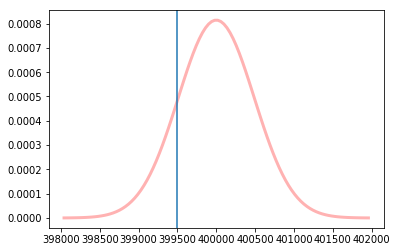

In [59]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

#функция, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

# границы промежутка, в котором будем строить аппроксимацию
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

#список из 100 чисел от left до right
x = linspace(left, right, 100)

ax = plt.subplot()

# рисуем график нормального распределения:
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=3, alpha=0.3)
plt.axvline(x=399500)

plt.show()

 Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна P(X<=399500).

In [60]:
y=399500
result = distr.cdf(y)
print(result)

0.15371708296369768


Итого, вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 0.15.

<a id='section8'></a> 
#### Заключение

Общий вывод
 
Проведен анализ данных сервиса аренды самокатов.
    
Предобработка выявила в данных дубли, которые были удалены. Дата поездки  сохранена в формате даты и времени.    
    
Проведен исследовательский анализ данных, который выявил:
    
- больше всего пользователей в Пятигорске,  меньше всего в Москве,
    
- 46% имеют подписку, 54% пользователей не имеют,
    
- наиболее активная категория пользователей - молодежь в возрасте около 25 лет,
    
- среднее расстояние, преодолеваемое пользователями, около 3 км,
    
- средняя длительность поездки составила 17,8 минут,
    
- по расстоянию и длительности поездки наблюдается небольшой всплеск числа пользователей в районе нуля, по всей видимости связанный с пробными поездками новых пользователей.
    
  Проверка статистических гипотез показала:
    
 - пользователи с подпиской в целом тратят больше времени на поездки, чем пользователи без подписки.
    
 - расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м
    
 - пользователи с подпиской в целом приносят больший доход, чем пользователи без подписки.
    
Исследованы маркетинговые акции с раздачей промокодов и рассылкой  push-уведомлений в мобильном приложении.
    
Выявлено количество промокодов на один бесплатный месяц подписки, достаточное  для привлечения 100 клиентов, продляющих подписку после пробного периода.
    
С помощью аппроксимации установлено распределение числа пользователей мобильного приложения, которые открывают push-уведомления, и найдена вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

    
